# Some Submissions

In [ ]:
from fastai.vision.all import *
import timm

In [ ]:
path = Path('paddy-disease-classification')

train_path = path / 'train_images'
train_files = get_image_files(train_path)

test_path = path/'test_images'
test_files = get_image_files(test_path).sorted()

In [5]:
train_df = pd.read_csv(path / 'train.csv')
train_df.head()

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

In [7]:
train_df[train_df.image_id.isin(['100804.jpg', '100867.jpg', '100918.jpg'])]

image_id  label variety  age
6545  100804.jpg  hispa   ADT45   70
6547  100867.jpg  hispa   ADT45   70
6549  100918.jpg  hispa   ADT45   70

In [8]:
train_df[train_df.image_id.isin(['100506.jpg', '100583.jpg', '101426.jpg'])]

image_id   label variety  age
7822  100506.jpg  normal   ADT45   60
7825  100583.jpg  normal   ADT45   60
7883  101426.jpg  normal   ADT45   60

In [10]:
train_df[train_df.image_id.isin(['100447.jpg', '101169.jpg', '102166.jpg'])]

image_id                  label variety  age
62  100447.jpg  bacterial_leaf_blight   ADT45   55
65  101169.jpg  bacterial_leaf_blight   ADT45   55
84  102166.jpg  bacterial_leaf_blight   ADT45   55

In [11]:
train_df[train_df.image_id.isin(['100552.jpg', '101461.jpg', '101600.jpg', '102137.jpg'])]

image_id                  label variety  age
701  100552.jpg  bacterial_leaf_streak   Zonal   70
714  101461.jpg  bacterial_leaf_streak   Zonal   70
715  101600.jpg  bacterial_leaf_streak   Zonal   70
723  102137.jpg  bacterial_leaf_streak   Zonal   70

<AxesSubplot:>

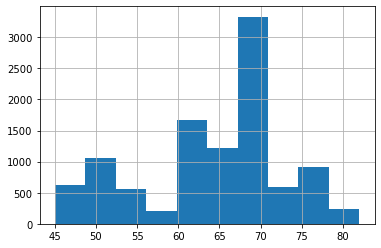

In [4]:
train_df.age.hist()

### DataBlock

In [5]:
# https://docs.fast.ai/tutorial.datablock.html

# Standard DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    # size = 128 for faster training
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [6]:
dls = dblock.dataloaders(train_path)

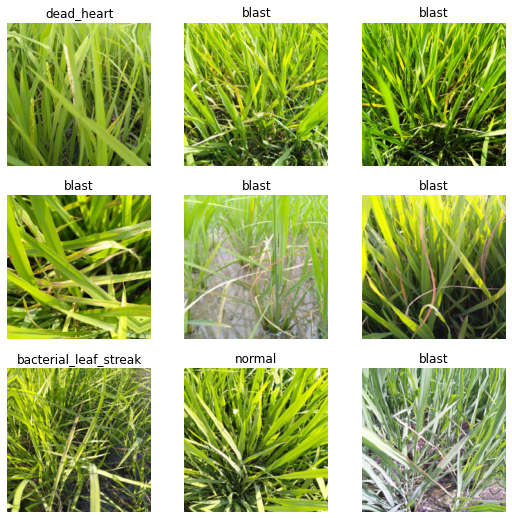

In [7]:
dls.show_batch()

## Finetuning from resnet34

This pipeline get 70th position on Kaggle, so I keep it documented here

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    # size = 128 for faster training
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = dblock.dataloaders(train_path)

In [9]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

In [10]:
learn.fine_tune(12, 0.01)

In [12]:
learn.export('learner-224-resnet34-12epochs-lr01.pkl')

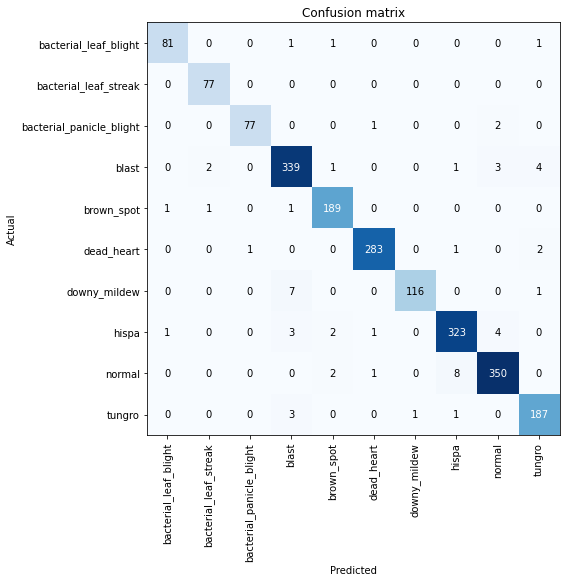

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [14]:
sample_submission = pd.read_csv(path/'sample_submission.csv')


In [15]:
test_dl = dls.test_dl(test_files)


In [16]:
preds, _ = learn.tta(dl=test_dl)
idxs = preds.argmax(dim=1)
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")
sample_submission['label'] = results

In [17]:
csv_file = 'subm' + '-224-resnet34-12epochs-lr01' +'_tta.csv'

sample_submission.to_csv(csv_file, index=False)

!head {csv_file}

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


## Esta fue la posición 70

In [54]:
#Esto fue lo que se subió a Kaggle
#NO EJECUTAR
learn.fine_tune(8, 0.01)

In [ ]:
# nvidia-smi --query-gpu=timestamp,power.draw,memory.total,utilization.memory,temperature.gpu,clocks.current.graphics,clocks.current.sm,clocks.current.memory --loop=1 --format=csv --filename=results-profile1.csv
# nvidia-smi --query-gpu=timestamp,power.draw,memory.total,utilization.memory,temperature.gpu,clocks.current.graphics,clocks.current.sm,clocks.current.memory --loop=1 --format=csv --filename=results-profile2.csv
# nvidia-smi --query-gpu=timestamp,power.draw,memory.total,utilization.memory,temperature.gpu,clocks.current.graphics,clocks.current.sm,clocks.current.memory --loop=1 --format=csv --filename=results-profile3.csv

In [55]:
sample_submission = pd.read_csv(path/'sample_submission.csv')
sample_submission.head()

image_id  label
0  200001.jpg    NaN
1  200002.jpg    NaN
2  200003.jpg    NaN
3  200004.jpg    NaN
4  200005.jpg    NaN

In [57]:
test_dl = dls.test_dl(test_files)

In [58]:
probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)
idxs

TensorBase([7, 8, 3,  ..., 8, 1, 5])

In [59]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [60]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [62]:
sample_submission['label'] = results
sample_submission.to_csv('subm-224-resnet34-8epochs.csv', index=False)
!head subm-224-resnet34-8epochs.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


## Esta fue la posición 30

In [29]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = dblock.dataloaders(train_path)

In [30]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

SuggestedLRs(valley=0.0006918309954926372, slide=0.0010000000474974513)

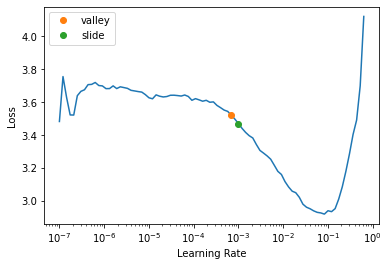

In [9]:
learn.lr_find(suggest_funcs=(valley, slide))

In [11]:
learn.fine_tune(16, 0.005)

In [10]:
export_name = '224-resnet34-16epochs-lr005'

#learn.export('model' + export_name + '.pkl')

In [37]:
learn = load_learner('./models/model224-resnet34-16epochs-lr005.pkl')

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

ValueError: not enough values to unpack (expected 3, got 2)

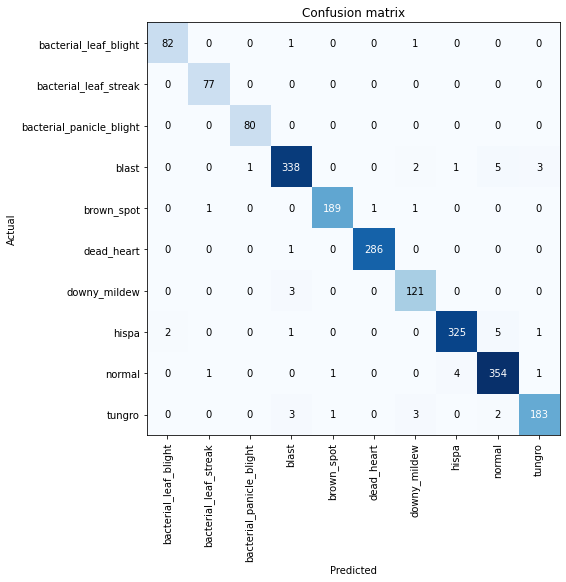

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

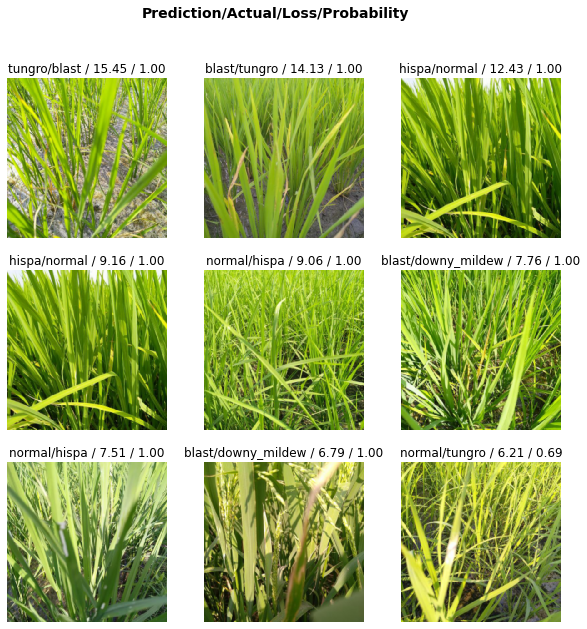

In [15]:
interp.plot_top_losses(9, figsize=(10,10))

In [20]:
sample_submission = pd.read_csv(path/'sample_submission.csv')
sample_submission.head()

image_id  label
0  200001.jpg    NaN
1  200002.jpg    NaN
2  200003.jpg    NaN
3  200004.jpg    NaN
4  200005.jpg    NaN

In [16]:
test_dl = dls.test_dl(test_files)
preds, _ = learn.tta(dl=test_dl)

In [22]:
idxs = preds.argmax(dim=1)
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [23]:
sample_submission['label'] = results

In [24]:
sample_submission.head()

image_id   label
0  200001.jpg   hispa
1  200002.jpg  normal
2  200003.jpg   blast
3  200004.jpg   blast
4  200005.jpg   blast

In [25]:
csv_file = 'subm' + export_name +'_tta.csv'

sample_submission.to_csv(csv_file, index=False)

!head {csv_file}

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


## Predict Normal vs Disease

- Voy a predecir Normal vs Disease y uso esa predicción como insumo para entrenar otro modelo, ¿ayudará?

In [5]:
import gc
def report_gpu():
    #print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()
    
report_gpu()

In [6]:
label = { r.image_id: r.label for _, r in train_df.iterrows() }

def normal_or_sick(p):
    out = 'normal'
    if label[p.name] != 'normal': out = 'sick'
    return out

In [31]:
print(len(train_df[train_df.label == 'normal']))
assert all([label[each]=='normal' for each in list(train_df[train_df.label == 'normal'].image_id)])

1764


In [32]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    n_inp = 1,    
    get_y = normal_or_sick,
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [33]:
des = dblock.datasets(train_path)
des.vocab

['normal', 'sick']

In [34]:
dls = dblock.dataloaders(train_path)

In [35]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

In [36]:
learn.fine_tune(15, 0.005)

In [39]:
valid = learn.dls.valid
preds, targs = learn.get_preds(dl=valid)

In [41]:
error_rate(preds, targs)

TensorBase(0.0096)

In [40]:
tta_preds, _ = learn.tta(dl=valid)
error_rate(tta_preds, targs)

TensorBase(0.0106)

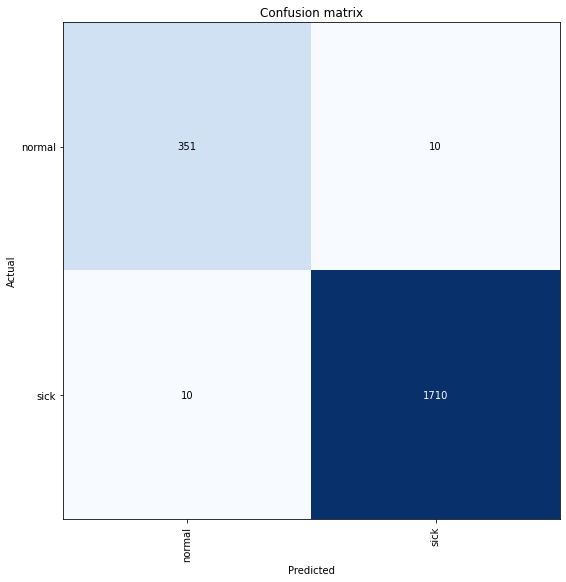

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [43]:
learn.export('class_normal_vs_sick.pkl')

In [51]:
# Esto falla
#learn2 = load_learner('class_normal_vs_sick.pkl')
#interp = ClassificationInterpretation.from_learner(learn2)
#interp.plot_confusion_matrix(figsize=(8,8))

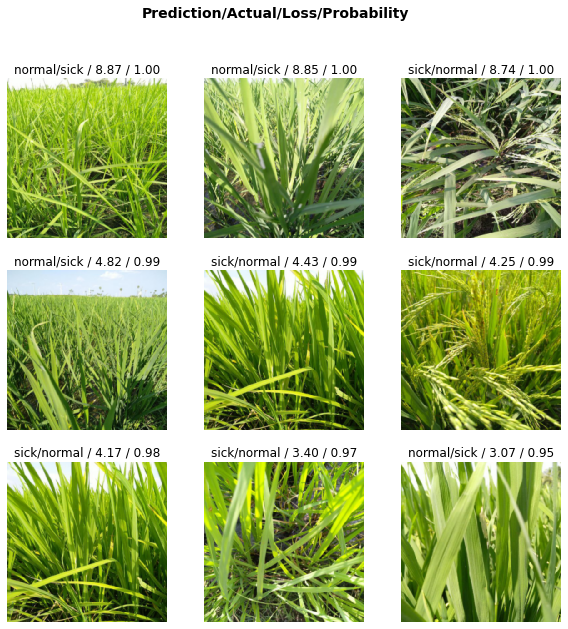

In [44]:
interp.plot_top_losses(9, figsize=(10,10))

In [76]:
len(learn.dls.items), len(learn.dls.train.items), len(learn.dls.valid.items)

(8326, 8326, 2081)

In [90]:
learn.dls.valid.items[interp.top_losses()[1][0]]

Path('paddy-disease-classification/train_images/normal/108705.jpg')

In [96]:
learn.dls.valid.items[interp.top_losses()[1][4]]

Path('paddy-disease-classification/train_images/normal/108065.jpg')

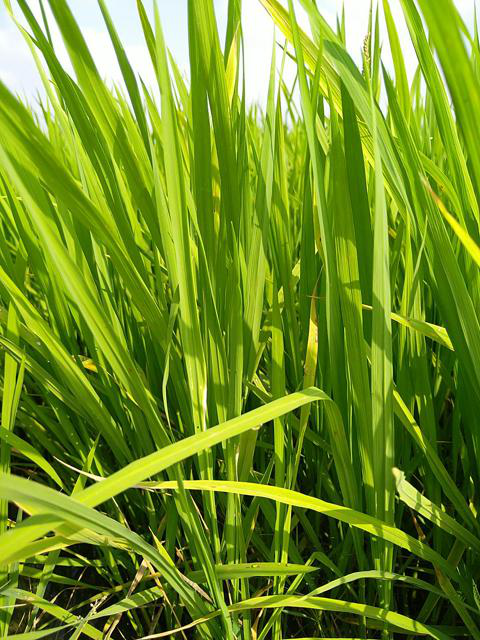

In [98]:
im = PILImage.create(learn.dls.valid.items[interp.top_losses()[1][4]])
im.thumbnail((480,640))
im

In [49]:
interp.top_losses()

(TensorBase([8.8673, 8.8478, 8.7365,  ..., -0.0000, -0.0000, -0.0000]),
 TensorBase([  79,  279,  175,  ..., 2070,  177, 1678]))

In [50]:
valid = learn.dls.valid
preds, targs = learn.get_preds(dl=valid)

In [51]:
error_rate(preds, targs)

TensorBase(0.0096)

In [55]:
test_dl = dls.test_dl(test_files)
preds, _ = learn.tta(dl=test_dl)

In [56]:
idxs = preds.argmax(dim=1)
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")
results

0         sick
1       normal
2         sick
3         sick
4         sick
         ...  
3464      sick
3465      sick
3466    normal
3467      sick
3468      sick
Name: idxs, Length: 3469, dtype: object

In [57]:
subm224_resnet34_16epochs_lr005_tta_df = pd.read_csv('subm224-resnet34-16epochs-lr005_tta.csv')
subm224_resnet34_16epochs_lr005_tta_df['normal_or_not'] = results
subm224_resnet34_16epochs_lr005_tta_df

image_id                  label normal_or_not
0     200001.jpg                  hispa          sick
1     200002.jpg                 normal        normal
2     200003.jpg                  blast          sick
3     200004.jpg                  blast          sick
4     200005.jpg                  blast          sick
...          ...                    ...           ...
3464  203465.jpg             dead_heart          sick
3465  203466.jpg                  hispa          sick
3466  203467.jpg                 normal        normal
3467  203468.jpg  bacterial_leaf_streak          sick
3468  203469.jpg             dead_heart          sick

[3469 rows x 3 columns]

In [75]:
filter = (subm224_resnet34_16epochs_lr005_tta_df.label != 'normal') & (subm224_resnet34_16epochs_lr005_tta_df.normal_or_not == 'normal')
filter

0       False
1       False
2       False
3       False
4       False
        ...  
3464    False
3465    False
3466    False
3467    False
3468    False
Length: 3469, dtype: bool

In [79]:
subm224_resnet34_16epochs_lr005_tta_df.loc[filter, 'label'] = 'normal'

In [82]:
csv_file = 'subm224-resnet34-16epochs-lr005_tta_normal_help.csv'
subm224_resnet34_16epochs_lr005_tta_df[['image_id', 'label']].to_csv(csv_file, index=False)

## Predict Blast vs No Blast

In [83]:
report_gpu()

In [84]:
label = { r.image_id: r.label for _, r in train_df.iterrows() }

def blast_or_not(p):
    out = 'non_blast'
    if label[p.name] == 'blast': out = 'blast'
    return out

In [85]:
print(len(train_df[train_df.label == 'blast']))
assert all([label[each]=='blast' for each in list(train_df[train_df.label == 'blast'].image_id)])

1738


In [87]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    n_inp = 1,    
    get_y = blast_or_not,
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
des = dblock.datasets(train_path)
des.vocab

['blast', 'non_blast']

In [88]:
dls = dblock.dataloaders(train_path)

In [89]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

In [90]:
learn.fine_tune(15, 0.005)

In [93]:
valid = learn.dls.valid
preds, targs = learn.get_preds(dl=valid)

In [94]:
error_rate(preds, targs)

TensorBase(0.0082)

In [95]:
tta_preds, _ = learn.tta(dl=valid)
error_rate(tta_preds, targs)

TensorBase(0.0096)

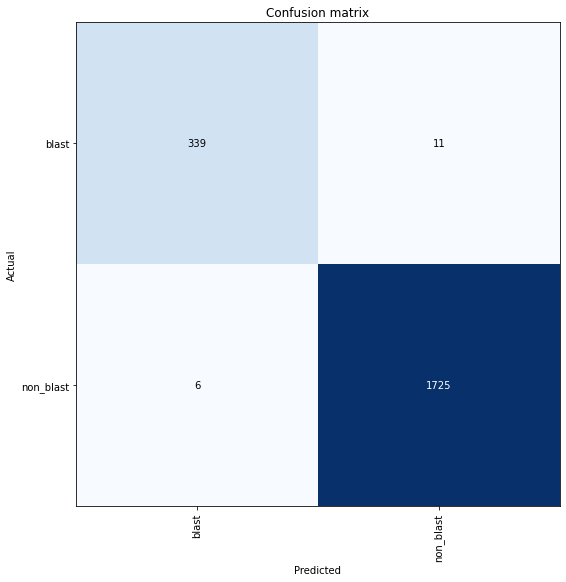

In [91]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [92]:
learn.export('class_blast_vs_no-blast.pkl')

In [96]:
probs, _, idxs = learn.get_preds(dl=valid, with_decoded=True)

In [118]:
dls.vocab

['blast', 'non_blast']

In [125]:
sum(idxs == 0)

TensorBase(345)

In [134]:
sum(preds[:,0] > 0.5)

TensorBase(345)

In [121]:
probs[idxs == 1]

TensorBase([[7.7331e-04, 9.9923e-01],
        [3.2445e-05, 9.9997e-01],
        [9.3581e-03, 9.9064e-01],
        ...,
        [7.1833e-06, 9.9999e-01],
        [2.0823e-06, 1.0000e+00],
        [7.3974e-05, 9.9993e-01]])

In [128]:
sum(tta_preds.argmax(dim=1) == 0)

TensorBase(346)

## Trying to use predictions as inputs

In [270]:
normal_vs_sick_learn = load_learner('class_normal_vs_sick.pkl', cpu=False)

blast_vs_no_blast_learn = load_learner('class_blast_vs_no-blast.pkl', cpu=False)

In [241]:
val_items = learn.dls.valid
trn_items = learn.dls.train

print(len(val_items.items))
print(len(trn_items.items))

2081
8326


In [235]:
val_preds1, val_targs1 = normal_vs_sick_learn.get_preds(dl=val_items)
trn_preds1, trn_targs1 = normal_vs_sick_learn.get_preds(dl=trn_items)

In [259]:
normal_vs_sick_learn.dls.vocab

['normal', 'sick']

In [249]:
val_preds1[0], val_targs1[0]

(TensorBase([6.9477e-07, 1.0000e+00]), TensorCategory(0))

In [250]:
val_preds1[1], val_targs1[1]

(TensorBase([9.9948e-01, 5.1930e-04]), TensorCategory(0))

In [266]:
print(sum(val_targs1 == 0))
print(sum(val_targs1 == 1))

TensorCategory(1731)
TensorCategory(350)


In [269]:
val_preds2, val_targs2 = blast_vs_no_blast_learn.get_preds(dl=val_items)
trn_preds2, trn_targs2 = blast_vs_no_blast_learn.get_preds(dl=trn_items)

KeyboardInterrupt: 

In [267]:
blast_vs_no_blast_learn.dls.vocab

['blast', 'non_blast']

In [268]:
print(sum(val_targs2 == 0))
print(sum(val_targs2 == 1))

TensorCategory(1731)
TensorCategory(350)


In [173]:
normal_vs_sick_preds = (
    {each.name: float(val_preds[idx][0]) for idx, each in enumerate(val_items.items)} |
    {each.name: float(trn_preds[idx][0]) for idx, each in enumerate(trn_items.items)}
)
len(normal_vs_sick_preds)

10407

In [206]:
train_df['normal_vs_sick_preds'] = train_df.image_id.map(normal_vs_sick_preds)


image_id   label   variety  age  normal_vs_sick_preds
1196   100373.jpg   blast     ADT45   45          4.230580e-04
1197   100636.jpg   blast     ADT45   45          2.434605e-04
1198   100738.jpg   blast     ADT45   45          8.646523e-07
1199   100758.jpg   blast     ADT45   45          6.828194e-05
1200   100765.jpg   blast     ADT45   45          1.184624e-02
...           ...     ...       ...  ...                   ...
7411   104795.jpg   hispa  Onthanel   70          1.917057e-01
7436   107343.jpg   hispa  Onthanel   70          9.451043e-02
9710   108887.jpg  tungro     ADT45   60          4.488641e-01
10097  107793.jpg  tungro     ADT45   70          4.182801e-01
10401  107253.jpg  tungro     Zonal   55          7.369626e-02

[1740 rows x 5 columns]

## Normal vs Sick as input

In [192]:
# normal_vs_sick_preds = { r.image_id: r.variety for _, r in train_df.iterrows() }

def get_normal_vs_sick_preds(p): return normal_vs_sick_preds[p.name]
    
normal_vs_sick_preds.__getitem__('100330.jpg')

0.9772408604621887

In [193]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock, CategoryBlock),
    n_inp = 2,
    
    get_x = (lambda o: o, get_normal_vs_sick_preds),
    get_y = parent_label,
    get_items=get_image_files,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
des = dblock.datasets(train_path)


In [194]:
des

(#10407) [(PILImage mode=RGB size=480x640, tensor(1.0000), TensorCategory(0)),(PILImage mode=RGB size=480x640, tensor(1.0000), TensorCategory(0)),(PILImage mode=RGB size=480x640, tensor(1.0000), TensorCategory(0)),(PILImage mode=RGB size=480x640, tensor(1.0000), TensorCategory(0)),(PILImage mode=RGB size=480x640, tensor(0.9999), TensorCategory(0)),(PILImage mode=RGB size=480x640, tensor(1.0000), TensorCategory(0)),(PILImage mode=RGB size=480x640, tensor(1.0000), TensorCategory(0)),(PILImage mode=RGB size=480x640, tensor(0.9999), TensorCategory(0)),(PILImage mode=RGB size=480x640, tensor(0.9999), TensorCategory(0)),(PILImage mode=RGB size=480x640, tensor(1.0000), TensorCategory(0))...]

In [195]:
dls = dblock.dataloaders(train_path)

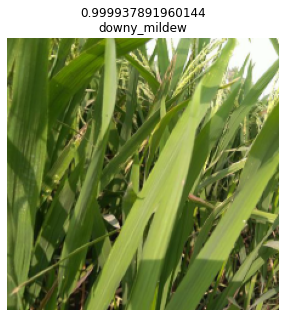

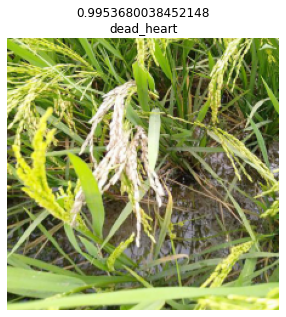

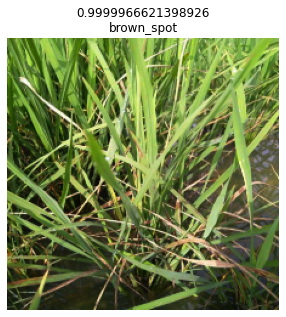

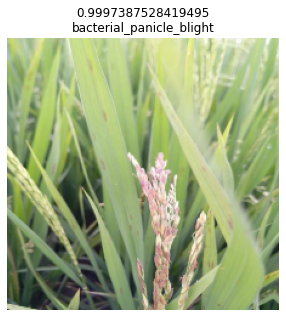

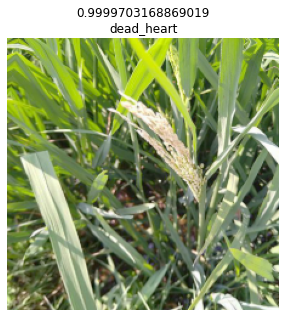

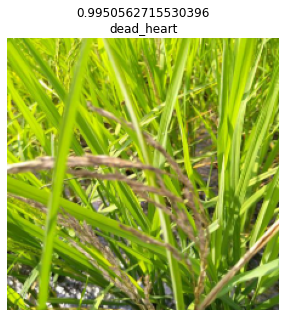

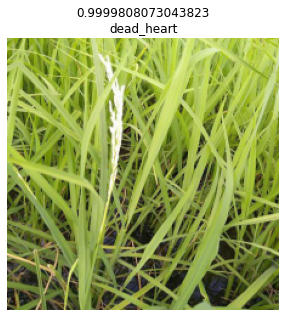

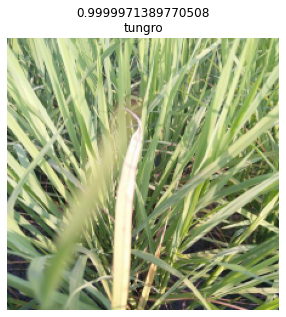

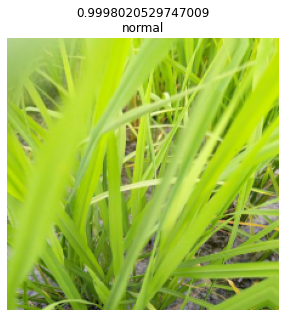

In [196]:
dls.show_batch()